In [8]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import LineCollection
from numpy import pi, cosh, exp, round, zeros, identity, arange, real, cos, sin, multiply, outer, flip
from numpy.fft import fft,ifft, fftfreq, fft2, ifft2
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import torch

import numpy as np  # Import numpy
import math
from numpy.linalg import inv, norm

In [26]:
def filter_div(u, v):
    u = flip(u, axis = 0)
    v = flip(v, axis = 0)

    L = 2*pi
    [Ny, Nx] = np.shape(u)

    # flip from matrix indexing to cartesian indexing do fft stuff
    u = (flip((u), axis=0))
    v = (flip((v), axis=0))
    alpha = 0 # 1e-10 # regularization parameter
    uHat = fft2(u)
    vHat = fft2(v)

    dx = L/(Nx)
    dy = L/(Ny)
    
    # see test_fft2.py to see how k's are arranged in python3
    kx = fftfreq(Nx, d = dx)*(2*pi)
    ky = fftfreq(Ny, d = dy)*(2*pi)
    kx[Nx//2] = 0.
    ky[Ny//2] = 0.
    # print("kx", kx)
    # KX, KY = np.meshgrid(kx, ky, indexing='ij')
    KX, KY = np.meshgrid(kx, ky)
    K2 = KX**2 + KY**2

    # divuHat = - Hat{(del.u_vec)}
    divuHat = -1j*(KX*uHat + KY*vHat)
    print("max(divu) = ", np.max(abs(np.real(ifft2(divuHat)))))

    # filter_ = 1.0/ (-KX**2 - KY**2 + alpha**2)
    # filter_[K2 == 0] = 0.
    # phiHat = divuHat*filter_
    phiHat = zeros(np.shape(divuHat), dtype=complex)

    # now everything is in cartesian indexing, ii for x, jj for y now
    for ii in range(0, Nx):
        for jj in range(0, Ny):
            k = KX[ii, jj]
            l = KY[ii, jj]

            if(k == 0 and l == 0):
                phiHat[ii, jj] = 0. # phase fixing condition, zero mean condition
            else:
                phiHat[ii, jj] = divuHat[ii, jj]/(-k**2 - l**2 + alpha**2)

    # du0_vec = grad phi => {du0Hat, dv0Hat} = {1j*k*phiHat, 1j*l*phiHat}
    du0Hat = 1j*KX*phiHat
    dv0Hat = 1j*KY*phiHat

    # method 1: if flipping
    du0 = real(ifft2(du0Hat)) # probably need scaling factor for ifft2
    # print("max(du0) = ", np.max(abs(u0)))
    # return to original matrix indexing
    du0 = (flip((du0), axis=0))
    u = flip((u), axis=0)
    u0 = du0 + u

    dv0 = real(ifft2(dv0Hat))
    # return to original matrix indexing
    dv0 = (flip((dv0), axis=0))
    v = flip((v), axis=0)
    v0 = dv0 + v
    
    u0 = flip(u0, axis = 0)
    v0 = flip(v0, axis = 0)
    return u0, v0

In [27]:
def div_and_curl_FD(x,y,u,v):
    # Compute the partial derivatives
    du_dx, du_dy = np.gradient(u, x, y)
    dv_dx, dv_dy = np.gradient(v, x, y)

    # Compute divergence
    div = du_dx + dv_dy

    # Compute curl
    curl = dv_dx - du_dy

    return div, curl


def div_and_curl_spectral(u,v):
    # X,Y = np.meshgrid(x,y)

    L = 2*pi
    [Nx, Ny] = np.shape(u)

    dx = L/Nx
    dy = L/Ny

    kx = fftfreq(Nx, d=dx)* (2 * pi)
    ky = fftfreq(Ny, d=dy)* (2 * pi)
    kx[Nx//2] = 0.
    ky[Ny//2] = 0.

    KX, KY = np.meshgrid(kx, ky)

    uHat = fft2(u)
    vHat = fft2(v)

    vortHat = 1j*(KX*vHat - KY*uHat)
    vort = np.real(ifft2(vortHat))

    divuHat = 1j*(KX*uHat + KY*vHat)
    div = np.real(ifft2(divuHat))

    return div, vort

div_FD  = 0.024538764687037598
curl_FD = 127.9461974974981
div_spec  = 4.4144137461054866e-13
curl_spec = 128.00000000000003


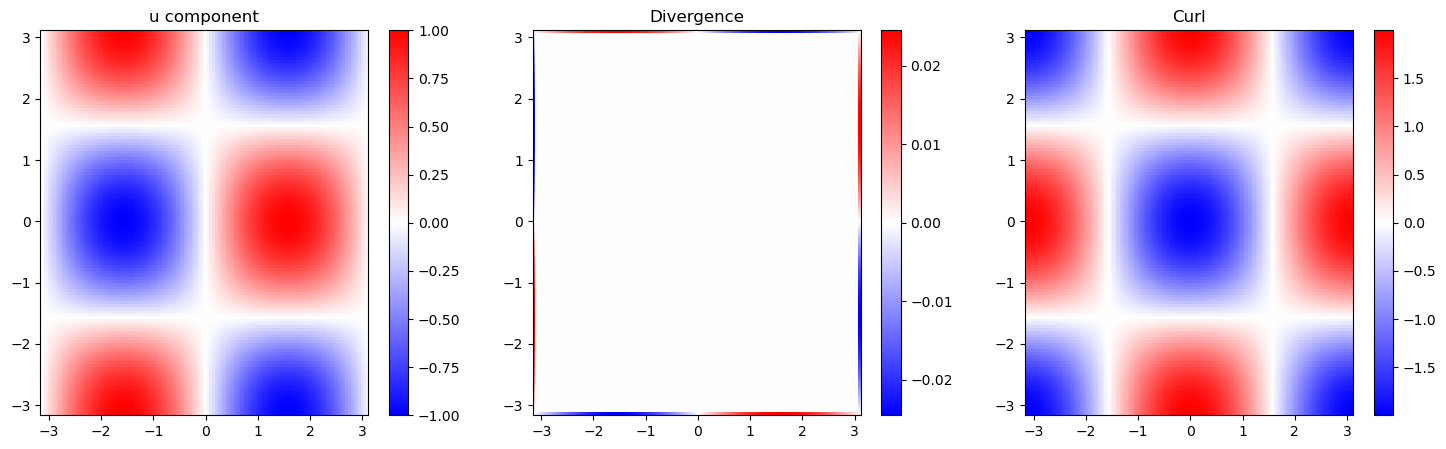

In [28]:
Lx = 2*pi
Ly = 2*pi

N = 128
dx = Lx/(N)
dy = Ly/(N)

x = np.arange(-Lx/2,Lx/2,dx)
y = np.arange(-Ly/2,Ly/2,dy)

X,Y = np.meshgrid(x,y)

u = np.sin(X)*np.cos(Y)
v = -np.cos(X)*np.sin(Y)

# omega = 1.0
# u =  omega*np.sqrt(X*X + Y*Y)*sin(np.arctan(Y/X))
# v = -omega*np.sqrt(X*X + Y*Y)*cos(np.arctan(Y/X))

# u = omega*sin(np.arctan(Y/X))
# v = -omega*cos(np.arctan(Y/X))

div_FD, curl_FD     = div_and_curl_FD(x,y,u,v)
div_spec, curl_spec = div_and_curl_spectral(u,v)

print(f'div_FD  = {np.max(div_FD)}')
print(f'curl_FD = {np.linalg.norm(curl_FD)}')

print(f'div_spec  = {np.max(div_spec)}')
print(f'curl_spec = {np.linalg.norm(curl_spec)}')

# fig, ax = plt.subplots()
# # ax = fig.add_subplot()
# im = ax.pcolormesh(x,y,u,cmap='bwr')
# fig.colorbar(im, ax=ax)
# plt.show()

# Plot the original vector field, divergence, and curl
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Plot u component
im_u = ax[0].pcolormesh(x, y, u, cmap='bwr')
ax[0].set_title('u component')
fig.colorbar(im_u, ax=ax[0])

# Plot divergence
im_div = ax[1].pcolormesh(x, y, div_FD, cmap='bwr')
ax[1].set_title('Divergence')
fig.colorbar(im_div, ax=ax[1])

# Plot curl
im_curl = ax[2].pcolormesh(x, y, curl_FD, cmap='bwr')
ax[2].set_title('Curl')
fig.colorbar(im_curl, ax=ax[2])

plt.show()

6.394653988050236
64.00000000000001
64.3234703001538
div_spec  = 10.503279593280283
curl_spec = 356.75094976289614
div_FD  = 10.503279593280283
curl_FD = 356.75094976289614


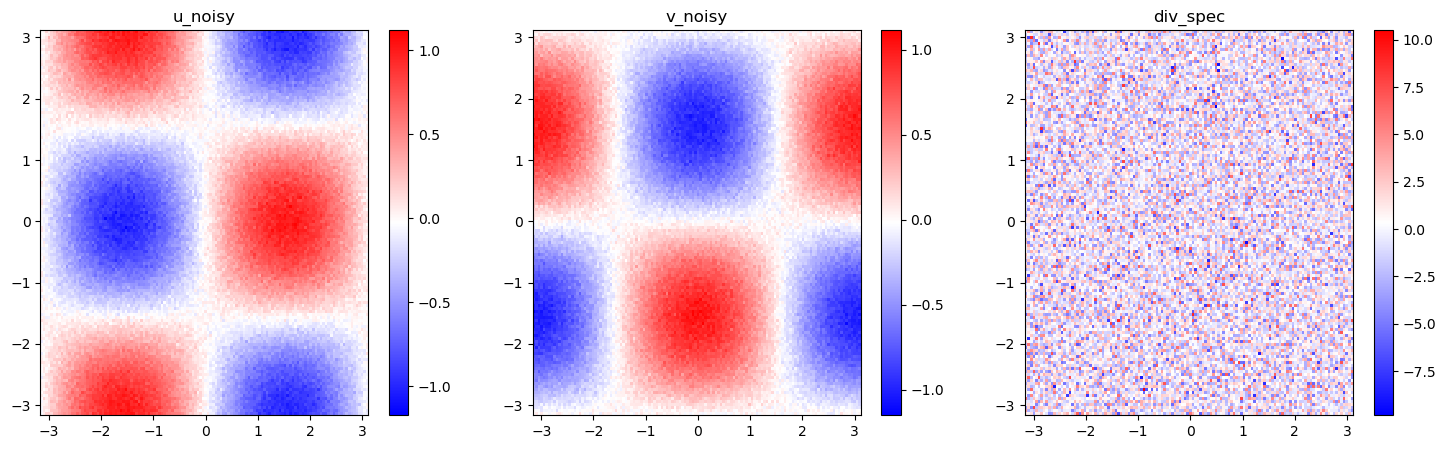

In [48]:
# Generate Gaussian noise
mean = 0
std_dev = 0.05
u_noise = np.random.normal(mean, std_dev, u.shape)
v_noise = np.random.normal(mean, std_dev, u.shape)

print(np.linalg.norm(u_noise))

u_noisy = u + u_noise
v_noisy = v + v_noise

print(np.linalg.norm(u))
print(np.linalg.norm(u_noisy))

div_spec, curl_spec = div_and_curl_spectral(u_noisy,v_noisy)
div_FD,   curl_FD   = div_and_curl_spectral(u_noisy,v_noisy)


print(f'div_spec  = {np.max(div_spec)}')
print(f'curl_spec = {np.linalg.norm(curl_spec)}')

print(f'div_FD  = {np.max(div_FD)}')
print(f'curl_FD = {np.linalg.norm(curl_FD)}')

# Plots
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Plot u component
im_u = ax[0].pcolormesh(x, y, u_noisy, cmap='bwr')
ax[0].set_title('u_noisy')
fig.colorbar(im_u, ax=ax[0])

# Plot divergence
im_div = ax[1].pcolormesh(x, y, v_noisy, cmap='bwr')
ax[1].set_title('v_noisy')
fig.colorbar(im_div, ax=ax[1])

# Plot curl
im_curl = ax[2].pcolormesh(x, y, div_spec, cmap='bwr')
ax[2].set_title('div_spec')
fig.colorbar(im_curl, ax=ax[2])

plt.show()

max(divu) =  10.503279593280283
np.linalg.norm(u_noisy-u_new) = 19.212820677015486
np.linalg.norm(v_noisy-v_new) = 19.234346611701266
np.linalg.norm(u-u_new) = 18.161817855166795
np.linalg.norm(v-v_new) = 18.195599146524124
div u_filter = 6.487358131589096e-13


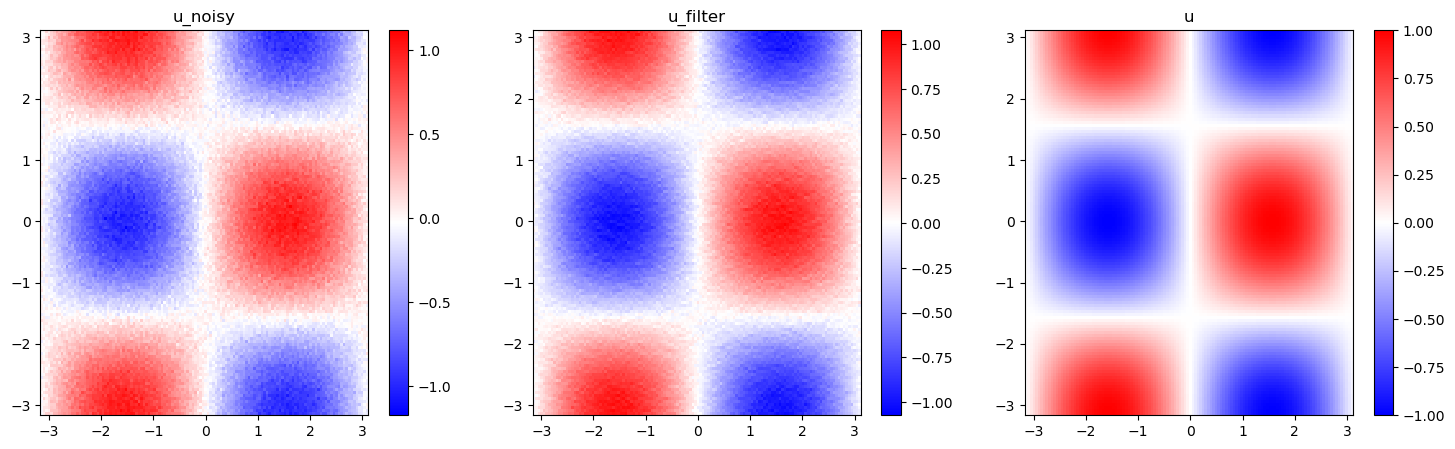

In [51]:
u_filter,v_filter = filter_div(u_noisy, v_noisy)

print(f'np.linalg.norm(u_noisy-u_new) = {np.linalg.norm(u_noisy-u_new)}')
print(f'np.linalg.norm(v_noisy-v_new) = {np.linalg.norm(v_noisy-v_new)}')

print(f'np.linalg.norm(u-u_new) = {np.linalg.norm(u-u_new)}')
print(f'np.linalg.norm(v-v_new) = {np.linalg.norm(v-v_new)}')


div_spec, curl_spec = div_and_curl_spectral(u_filter, v_filter)

print(f'div u_filter = {np.linalg.norm(div_spec)}')

# Plots
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Plot u component
im_u = ax[0].pcolormesh(x, y, u_noisy, cmap='bwr')
ax[0].set_title('u_noisy')
fig.colorbar(im_u, ax=ax[0])

# Plot divergence
im_div = ax[1].pcolormesh(x, y, u_filter, cmap='bwr')
ax[1].set_title('u_filter')
fig.colorbar(im_div, ax=ax[1])

# Plot curl
im_curl = ax[2].pcolormesh(x, y, u, cmap='bwr')
ax[2].set_title('u')
fig.colorbar(im_curl, ax=ax[2])

plt.show()